# Very strong II inhibition causes very fast inhibitory neuron spiking

In [1]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt
import attractor_network

INFO       Cache size for target 'cython': 2721419028 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\Dominic\.cython\brian_extensions' directory. [brian2]


In [8]:
def run_network(network: attractor_network.AttractorNetwork, params: dict):
	network.reset()
	network.params.update(params)
	network.run_with_inputs(warm_up_duration, [100*b2.Hz if 3<=i<=5 else 40*b2.Hz for i in range(network.num_excitatory)])
	network.run_with_inputs(duration, 0)

def plot_results(network: attractor_network.AttractorNetwork):
	fig, axs = plt.subplots(3, 1, figsize=(12,8), sharex=True)
	assert(isinstance(axs, np.ndarray))
	axs[0].plot(network.monitor_e.t/b2.ms, network.monitor_e.i[:], '.b')
	axs[0].set_ylabel('Neuron index')
	axs[0].set_ylim([0,network.num_excitatory])
	axs[0].set_title('E spikes')
	axs[1].plot(network.monitor_i.t/b2.ms, network.monitor_i.i[:], '.r')
	axs[1].set_ylabel('Neuron index')
	axs[1].set_title('I spikes')
	axs[2].plot(network.state_monitor_i.t/b2.ms, network.state_monitor_i.v.T/b2.mV)
	axs[2].set_xlabel('Time (ms)')
	axs[2].set_ylabel('Neuron Voltage (mV)')
	axs[2].set_title('Inhibitory neuron membrane potential')
	plt.tight_layout()
	plt.show()

In [3]:
b2.defaultclock.dt = 0.1*b2.ms # brian default
network = attractor_network.AttractorNetwork()
warm_up_duration = 200*b2.ms
duration = 200*b2.ms

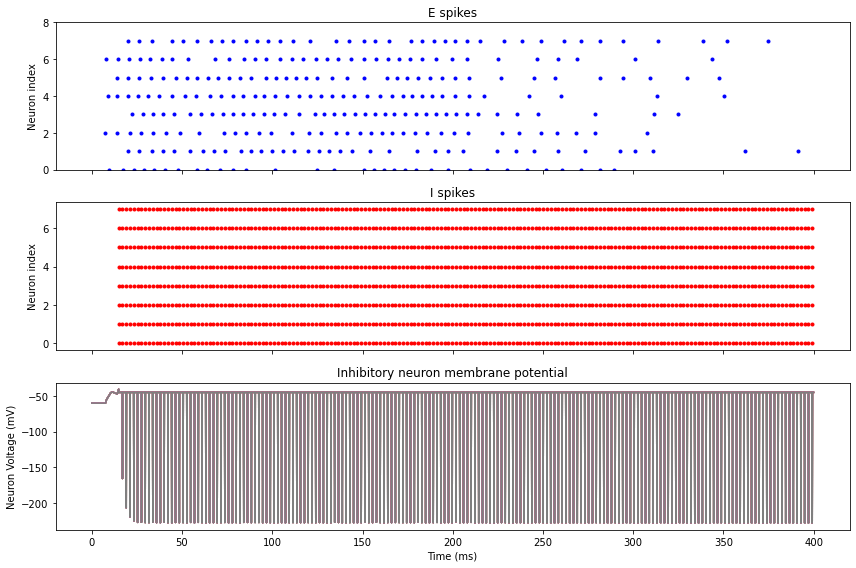

In [9]:
params = {
	'weight_ee': 2,
	'stdev_ee': 0.6,
	'weight_ei': 1,
	'weight_ie': 0,
	'weight_ii': 100,
	'weight_input': 20,
	'tau_e': 10*b2.ms,
	'v_noise_i': 0.1*b2.mV/b2.ms,
}

run_network(network, params)
plot_results(network)

The inhibition is strong enough to force the neuron's membrane voltage below the -85 mV potential for the inhibitory synapses, so the inhibitory synapses now pull the neuron voltage up. The rate of change of voltage is proportional to the conductance of these channels, which increases each time a spike occurs. At some point the conductance is so high that the membrane potential increases above the threshold in one timestep, causing the neurons to fire, the conductance to increase, and this process to repeat.

To avoid this, the integration timestep should be decreased, or the maximum inhibition limited.

The equations are:
$$\frac{\text{d}v}{\text{d}t} = \frac{1}{\tau_m} \left((v_{\text{rest}} - v) + \frac{1}{R_m}(I_{\text{syn},E} + I_{\text{syn},I})\right)$$
$$I_{\text{syn},E} = g_E (V_E - v)$$
$$I_{\text{syn},I} = g_I (V_I - v)$$
$$\frac{\text{d}g_E}{\text{d}t} = \frac{g_E}{\tau_E}$$
$$\frac{\text{d}g_I}{\text{d}t} = \frac{g_I}{\tau_I}$$
where $V_E= 0$ mV and $V_I = -85$ mV.

If $v$ is very low, $v_{\text{rest}} - v$, $I_{\text{syn},E}$, and $I_{\text{syn},I}$ all pull the voltage strongly upwards, and because of the discrete integration timestep the voltage jumps above the threshold $-52$ mV in one timestep.